# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", module="e3nn")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pathlib
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch

from ase import Atoms
from ase.io.jsonio import encode
from ase.visualize.plot import plot_atoms

from mace.calculators import MACECalculator

from condevo.es.guidance import KNNNoveltyCondition

from cluster import load_lj_cluster, evaluate_lj_population_torch
from charlx import AtomsFixer, AtomsRelaxer, AtomsTSOptimizer, CHARLX
from condition import OriginCondition
from run import CorrectedApplyLimitsObjective, run_evo
from ase.visualize import view
from view import view_results

torch.set_default_dtype(torch.float64)

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);


def plot_atoms_without_axes(atoms):
    fig, ax = plt.subplots()
    plot_atoms(atoms, ax=ax);
    ax.axis("off")

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


## 1. Lennard-Jones (LJ) cluster

The first example is a CHARLX evolution of the Lennard-Jones cluster with 13 atoms (LJ-13). The coordinates for the global minimum are loaded from files saved in the directory `data/wales/`. Files for clusters with 13, 31 and 38 atoms are available, other files with clusters up to 150 atoms can be downloaded as a `.tar` file from `https://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html`. After loading, additional information is shown: `max_span` (the maximum span of the structure used for conditioning), `dimensions` (number of atoms times three), `symbols` (chemical symbols for the `ase.atoms.Atoms` object) and `rep` (string representation for the destination path of the evolution). Also given is the energy of the structure, calculated by the `evaluate_lj_population_torch()` function, together with a visualiation of the cluster. For an interactive plot, comment in the last line `view(lj_atoms);`.

### Founder

We can now start with the configuration of the evolution. First, we define the randomized LJ-13 cluster from above as the `founder` structure for our evolution.

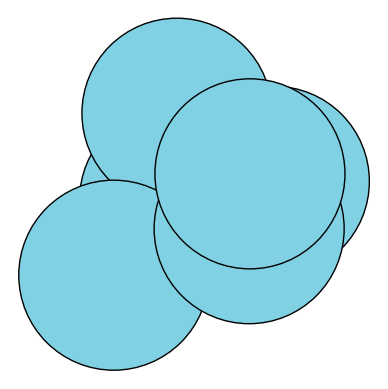

In [3]:
N_ATOMS = 7 # 13, 31, 38

# Initialize founder structure
lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=SEED,
)
founder = Atoms(symbols, np.reshape(lj_cluster_rand, (-1, 3)))

plot_atoms_without_axes(founder)

In [4]:
from sella import Sella

In [8]:
from ase.calculators.lj import LennardJones
founder.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

In [20]:
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

steps = 1000

ts_optimizer = AtomsTSOptimizer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    fmax=0.001,
    steps=steps,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)

opt_atoms = ts_optimizer.optimize_atoms(founder, steps)



In [22]:
#plot_atoms_without_axes(opt_atoms)
opt_atoms.get_potential_energy()

np.float64(-15.026438101203855)

In [25]:
from ase.vibrations import Vibrations

def quantify_saddle_point(atoms, name='ts_check'):
    """
    Quantifies the quality of a saddle point by calculating vibrational frequencies.
    Returns a dictionary of results.
    """
    # 1. Run the vibration analysis
    # Note: Ensure the atoms object has a calculator attached!
    vib = Vibrations(atoms, name=name)
    vib.run()
    
    # 2. Get the frequencies (in meV or cm^-1)
    # real_freqs will be negative for imaginary modes in ASE
    freqs = vib.get_frequencies()
    
    # 3. Identify imaginary frequencies
    # ASE represents imaginary frequencies as complex numbers; 
    # np.iscomplex or checking if the value is essentially "negative" works.
    imaginary_modes = [f for f in freqs if np.iscomplex(f) or f < 0]
    
    results = {
        "is_saddle": len(imaginary_modes) == 1,
        "n_imaginary": len(imaginary_modes),
        "imaginary_freq": imaginary_modes[0] if len(imaginary_modes) > 0 else None,
        "all_freqs": freqs
    }
    
    # Clean up files created by ASE Vibrations
    vib.clean()
    
    return results

In [26]:
quantify_saddle_point(opt_atoms)

{'is_saddle': False,
 'n_imaginary': 6,
 'imaginary_freq': np.complex128(242.11301673747155j),
 'all_freqs': array([0.00000000e+00+2.42113017e+02j, 0.00000000e+00+2.32524533e+01j,
        0.00000000e+00+1.99429112e+01j, 0.00000000e+00+1.70768889e+01j,
        0.00000000e+00+1.30994145e-05j, 0.00000000e+00+1.03064101e-05j,
        1.40987652e-05+0.00000000e+00j, 2.21274859e+02+0.00000000e+00j,
        5.45506830e+02+0.00000000e+00j, 6.12337197e+02+0.00000000e+00j,
        7.32321878e+02+0.00000000e+00j, 8.33797464e+02+0.00000000e+00j,
        8.92701572e+02+0.00000000e+00j, 9.39261843e+02+0.00000000e+00j,
        1.04272775e+03+0.00000000e+00j, 1.09410686e+03+0.00000000e+00j,
        1.20681231e+03+0.00000000e+00j, 1.29764303e+03+0.00000000e+00j,
        1.32856896e+03+0.00000000e+00j, 1.43417783e+03+0.00000000e+00j,
        1.53309597e+03+0.00000000e+00j])}

In [ ]:
def scan_imaginary_mode(atoms, mode_index=0, steps=10, amplitude=0.5):
    vib = Vibrations(atoms)
    vib.run()
    
    # Get the displacement vector for the imaginary mode
    mode = vib.get_mode(mode_index)
    original_positions = atoms.get_positions()
    
    energies = []
    displacements = np.linspace(-amplitude, amplitude, steps)
    
    for d in displacements:
        atoms.set_positions(original_positions + d * mode)
        energies.append(atoms.get_potential_energy())
    
    # Reset atoms to original state
    atoms.set_positions(original_positions)
    return displacements, energies

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from ase.vibrations import Vibrations

def scan_and_plot_imaginary_mode(atoms, steps=15, amplitude=0.5):
    """
    Scans the PES along the first imaginary mode and plots the result.
    """
    # 1. Run Vibrations to get the Hessian/Eigenvectors
    vib = Vibrations(atoms, name='ts_scan')
    vib.run()
    
    # Mode 0 is usually the most imaginary (largest negative freq)
    mode_vec = vib.get_mode(0) 
    original_pos = atoms.get_positions().copy()
    
    displacements = np.linspace(-amplitude, amplitude, steps)
    energies = []

    print("Starting displacement scan...")
    for d in displacements:
        atoms.set_positions(original_pos + d * mode_vec)
        # Ensure your atoms object has a calculator attached!
        e = atoms.get_potential_energy()
        energies.append(e)
        print(f"Displacement: {d:6.3f} | Energy: {e:10.6f} eV")

    # Reset atoms to original TS structure
    atoms.set_positions(original_pos)
    vib.clean()

    # 2. Plotting the results
    plt.figure(figsize=(8, 5))
    plt.plot(displacements, energies, 'o-', color='#2c3e50', linewidth=2)
    
    # Highlighting the TS point
    plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Original TS')
    
    plt.title("PES Scan Along Imaginary Mode (Saddle Point Cross-Section)")
    plt.xlabel("Displacement along Eigenvector (Å)")
    plt.ylabel("Potential Energy (eV)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.show()

    return displacements, energies

Starting displacement scan...
Displacement: -0.500 | Energy: -15.052840 eV
Displacement: -0.429 | Energy: -15.045952 eV
Displacement: -0.357 | Energy: -15.040050 eV
Displacement: -0.286 | Energy: -15.035175 eV
Displacement: -0.214 | Energy: -15.031360 eV
Displacement: -0.143 | Energy: -15.028626 eV
Displacement: -0.071 | Energy: -15.026984 eV
Displacement:  0.000 | Energy: -15.026438 eV
Displacement:  0.071 | Energy: -15.026980 eV
Displacement:  0.143 | Energy: -15.028592 eV
Displacement:  0.214 | Energy: -15.031249 eV
Displacement:  0.286 | Energy: -15.034915 eV
Displacement:  0.357 | Energy: -15.039546 eV
Displacement:  0.429 | Energy: -15.045092 eV
Displacement:  0.500 | Energy: -15.051491 eV


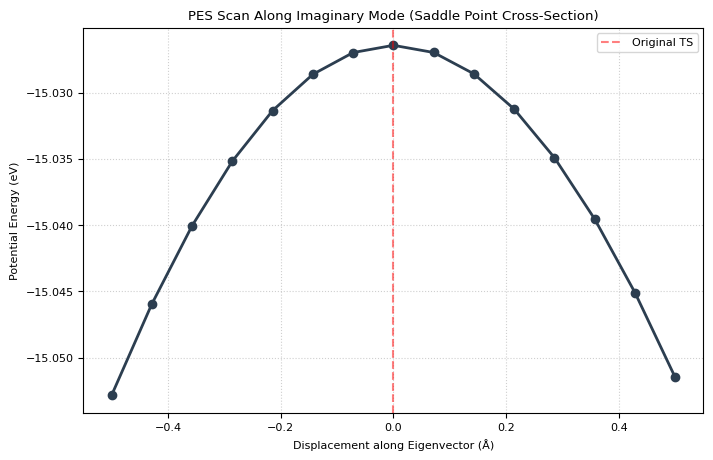

(array([-0.5       , -0.42857143, -0.35714286, -0.28571429, -0.21428571,
        -0.14285714, -0.07142857,  0.        ,  0.07142857,  0.14285714,
         0.21428571,  0.28571429,  0.35714286,  0.42857143,  0.5       ]),
 [np.float64(-15.052840440340333),
  np.float64(-15.045951935921561),
  np.float64(-15.040049777536812),
  np.float64(-15.035175257660836),
  np.float64(-15.031359949433872),
  np.float64(-15.028625634501674),
  np.float64(-15.026984284440262),
  np.float64(-15.026438101203855),
  np.float64(-15.026979620618407),
  np.float64(-15.028591881539827),
  np.float64(-15.031248661920033),
  np.float64(-15.0349147816925),
  np.float64(-15.039546471117031),
  np.float64(-15.045091802027926),
  np.float64(-15.05149117832466)])

In [30]:
scan_and_plot_imaginary_mode(opt_atoms)

In [ ]:
# Initialize fixing parameters
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

fixed_indices, frozen_indices, free_indices = fixer.get_indices(founder)

# NO RELAXATION
"""
# Initialize relaxing parameters
relaxer = AtomsRelaxer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    optimizer="FIRE",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)"""

####################################
# Initialize TS optimizer

ts_optimizer = AtomsTSOptimizer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)


# Initialize condition around the origin
condition_obj = OriginCondition(
    n_atoms=relaxer.free_n_atoms,
    target=1.0,
    kwargs={"cond_threshold": max_span},
)

# Initialize evolutionary algorithm
es = CHARLX
es_config = dict(
    x0=relaxer.free_positions,
    fixer=fixer,
    relaxer=relaxer,
    conditions=(condition_obj, KNNNoveltyCondition()),
    popsize=16,
    n_gens=3,
    sigma_init=0.5,
    selection_pressure=20.0,
    elite_ratio=0.15,
    crossover_ratio=0.125,
    mutation_rate=0.05,
    diff_batch_size=256,
    diff_max_epoch=1000,
    buffer_size=1000,
    is_genetic_algorithm=True,
    adaptive_selection_pressure=True,
    readaptation=False,
    forget_best=False,
)

# Initialize neural network
nn = "MLP"
nn_config = dict(
    num_hidden=96,
    num_layers=8,
    activation="LeakyReLU",
    num_params=relaxer.dimensions,
    num_conditions=len(es_config["conditions"]),
)

# Initialize diffusion model
diff = "GGDDIM"
diff_config = dict(
    num_steps=1000,
    lamba_range=1.0,
    geometry="radial",
    axis=None,
    lower_threshold=0.0,
    upper_threshold=max_span*1.5,
    diff_origin=[0.0, 0.0, 0.0],
    overlap_penalty=True,
    train_on_penalty=True,
)


# Initialize objective that will be maximized
obj = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="evaluate_population_with_calc",
    foo_kwargs={"obj_params": relaxer.encode_params()},
    maximize=True,
    dim=relaxer.dimensions,
)

In [ ]:
# Define destination path for output data
dst = f"output/{rep}"
dst += f"_P-{es_config["popsize"]}"
dst += f"_G-{es_config["n_gens"]}"
dst += f"_F-{relaxer.fmax}"
dst += f"_S-{relaxer.steps}"
dst += f"_U-{diff_config['upper_threshold']:.3f}"

# Remove old folder before new evolution
shutil.rmtree(dst, ignore_errors=True)

# Execute CHARLX evolution
evo = run_evo(
    generations=es_config["n_gens"],
    es=es,
    es_config=es_config,
    nn=nn,
    nn_config=nn_config,
    diff=diff,
    diff_config=diff_config,
    objective=obj,
    dst=dst,
    params={"save_diffusion": False},
)


### View results

loading data from output/LJ-7_P-16_G-3_F-0.001_S-1000_U-2.337/ES_CHARLX-objective_evaluate_population_with_calc.h5
Initial Structure Energy: 1589.4334 eV


=== Evolution Strategy Config ===
x0                       : tensor([-0.8123, -0.9446,  0.6437, -0.1078,  0.8623,  0.0761,  0.7068,  0.1861,
         1.2905,  0.9789,  0.1020,  0.8020,  0.0422, -0.1005, -1.0367,  0.6977,
        -0.4260,  0.8356, -0.1341, -0.1062, -0.4429])
fixer                    : AtomsFixer(fix_func=get_fixed_by_list, fix_list=[], fix_axis=None, fix_threshold=None, freeze_func=None, freeze_list=[], freeze_axis=None, freeze_threshold=None, fix_center=None, fix_radius=None)
relaxer                  : AtomsRelaxer(founder_atoms=Atoms(symbols='Ar7', pbc=False), fixed_indices=[], frozen_indices=[], free_indices=[0, 1, 2, 3, 4, 5, 6], calc=<ase.calculators.lj.LennardJones object at 0x105c8c080>, optimizer=<class 'ase.optimize.fire.FIRE'>, fmax=0.00100, steps=1000, logfile=None, multiproc=True, n_proc=16, device=cpu, s

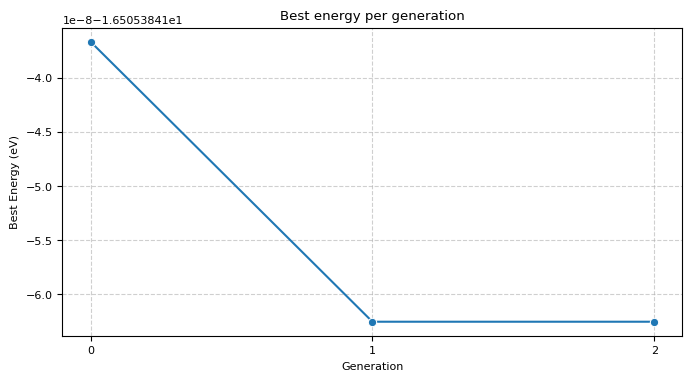

,Results
Initial energy (eV),1589.433392
Final best energy (eV),-16.505384
"Improvement vs initial (ΔE, eV)",1605.938777
Global best energy (eV),-16.505384
Best generation (1-based),2.000000
Generations run,3.000000


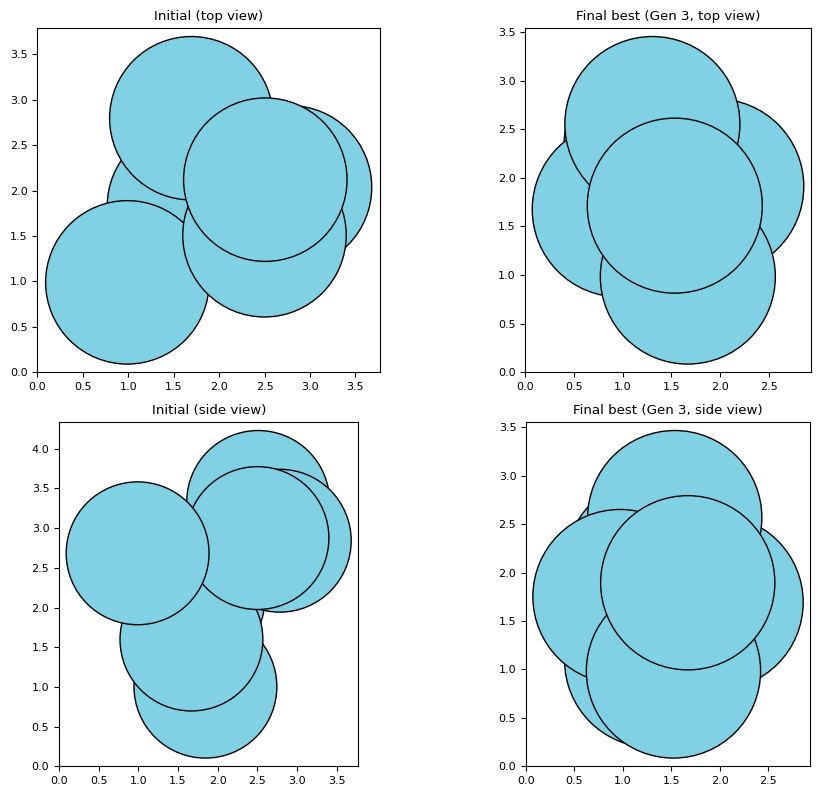

In [6]:
# Analyze output energies and structures
view_results(dst=dst, sort_samples=True, show=False)
